In [70]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [71]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [72]:
from config.params import FusionParams
from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import create_stochastic_avail_price_process, plot_price

from real_data_fetcher import fetch

from config.psub import psub


# Price Traj Generation

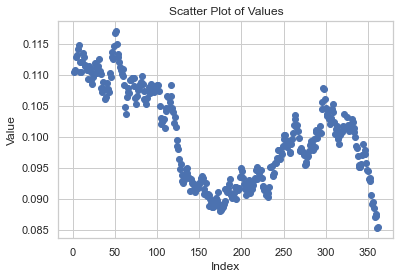

0.08520908974753211


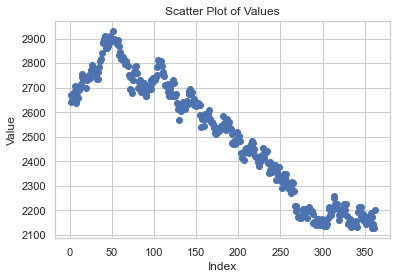

2126.007713226597


In [73]:
# types
Run = int
Timestep = int

avl_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0)
plot_price(avl_price_samples)
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=1500, target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples)
print(min(eth_price_samples))



In [74]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(min(avl_price_samples))

# plot_price(eth_price_samples) 
# print(min(eth_price_samples))

# Setup

In [75]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.11045334283779258


In [76]:
# Fixed parameters
def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
    total_fdv = total_supply * avl_price
    return total_fdv

init_total_fdv = fixed_params(avl_price = AVL_initial_price)

In [77]:
constants = {
    "total_supply": 10_000_000_000,
    "init_total_fdv": init_total_fdv,
    "native_staking_ratio": 0.3,
    "upper_rewards_to_fusion_pct": 0.5,
}




In [78]:
## create maxi agents

agents = AgentStake.create_maxi_agents(
    target_composition={'AVL': 0, 'ETH': 1, 'BTC': 0},  # 50% AVL, 30% ETH, 20% BTC
    total_tvl=1  # $1M total TVL
)

In [79]:
rewards_result = calculate_reward_allocation(
    constants=constants,
    avl_price=0.1,
    total_tvl=250e6,
    avl_stake_pct=0.15,
    target_avl_yield=0.15,
    target_eth_yield=0.035
)

assert rewards_result["capped"] == False


fusion_pct: 0.38419117647058826


# Simulation

In [80]:
# system parameters
parameters = FusionParams(
    constants=[constants],  # Wrap in list for multiple runs
    avl_price_samples=[avl_price_samples],  # List of price trajectories
    eth_price_samples=[eth_price_samples],
    rewards_result=[rewards_result],  # List of reward results
    agents=[agents]  # List of agent configurations
).__dict__

params = parameters


In [81]:
avl_price_process = params["avl_price_process"]
for i in range(10):
    avl_new_price = avl_price_process[0](i)
    print(avl_new_price- avl_price_samples[i])


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [82]:
# initial conditions

initial_conditions = {
    "timestep": 0,
    
    # security shares
    "AVL_security_pct": 0 * 100, # in cold start, all stake is in AVAIL
    "ETH_security_pct": 1 * 100,
    "total_security": 0,
    "total_fdv": init_total_fdv,

    # staking ratios
    "staking_ratio_all": constants["native_staking_ratio"],
    "staking_ratio_avl_fusion": 0.0,
    "staking_ratio_eth_fusion": 0.0,

    # inflation and rewards metrics
    "inflation_rate": rewards_result["init_inflation_rate"],
    "total_annual_inflation_rewards_in_avl": rewards_result["total_inflation_rewards_in_avl"],
    "total_annual_inflation_rewards_usd": rewards_result["total_inflation_rewards_usd"],
    "total_annual_rewards_fusion_usd": rewards_result["required_rewards"], # total rewards allocated to fusion in usd
    
    # agent states
    "agents": agents, # include token prices

    # yield metrics
    "avg_yield": 0,
    "yield_pcts": {"avl_maxi": 0, "eth_maxi": 0},

    # admin params
    "fusion_rewards_allocation": rewards_result["fusion_allocation_pct"], # % of total rewards allocated to fusion
    "avl_rewards_allocation": rewards_result["avl_rewards_pct"],

}






In [83]:
# Add validation checks
assert len(parameters['avl_price_process']) == 1, "Should have 1 price process"
assert parameters['avl_price_process'][0](0) == avl_price_samples[0], "Price mismatch"
#assert 'run' in initial_conditions, "Missing run key in initial state"



In [84]:
avl_agent = agents['avl_maxi']
avl_agent.total_tvl
avl_agent.add_rewards(100)

In [85]:
# run simulation

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=300, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


[DEBUG] update_token_prices
{'avl_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0.0, price=np.float64(0.11045334283779258)), 'ETH': AssetAllocation(pct=0.0, balance=0, price=np.float64(2643.153816623639)), 'BTC': AssetAllocation(pct=0.0, balance=0, price=30000)}, curr_annual_rewards_avl=100, accu_rewards_avl=0.273972602739726), 'eth_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(0.11045334283779258)), 'ETH': AssetAllocation(pct=np.float64(1.0), balance=0.0003333333333333333, price=np.float64(2643.153816623639)), 'BTC': AssetAllocation(pct=np.float64(0.0), balance=0, price=30000)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0), 'btc_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=np.float64(0.11045334283779258)), 'ETH': AssetAllocation(pct=0.0, balance=0, price=np.float64(2643.153816623639)), 'BTC': AssetAllocation(pct=0.0, balance=0.0, price=30000)}, curr_annual_rewards_avl=0.0, accu_

In [86]:
print(df)
df.to_csv('simulation_results.csv', index=False, encoding='utf-8')

      timestep  AVL_security_pct  ETH_security_pct  total_security  \
0            0                 0               100    0.000000e+00   
1            1                 0               100    0.000000e+00   
2            1                 0               100    0.000000e+00   
3            1                 0               100    0.000000e+00   
4            1                 0               100    5.000001e+06   
...        ...               ...               ...             ...   
1796       300                 0               100    6.690459e+08   
1797       300                 0               100    6.690459e+08   
1798       300                 0               100    6.692535e+08   
1799       300                 0               100    6.692535e+08   
1800       300                 0               100    6.692535e+08   

         total_fdv  staking_ratio_all  staking_ratio_avl_fusion  \
0     1.104533e+09                0.3                       0.0   
1     1.104533e+09       

In [87]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [88]:

fig= visualizations.plot_security_pct(
    df
)
pio.show(fig)


In [89]:
fig= visualizations.plot_total_security(
    df
)
pio.show(fig)

In [90]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [91]:
fig = visualizations.plot_yield_pct(
    df
)
pio.show(fig)

In [92]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df
)
pio.show(fig)